In [1]:
import random
import copy
import numpy as np

class Board:
    def __init__(self, size=3):
        self.size = size
        self.board = [[' ' for _ in range(size)] for _ in range(size)]

    def display(self):
        for row in self.board:
            print(" | ".join([cell if cell != ' ' else ' ' for cell in row]))
            print("-" * (self.size * 4 - 1))
        print("\n")

    def is_valid_move(self, row, col):
        return 0 <= row < self.size and 0 <= col < self.size and self.board[row][col] == ' '

    def make_move(self, row, col, player):
        if self.is_valid_move(row, col):
            self.board[row][col] = player
            return True
        else:
            return False

    def check_winner(self):
        lines = []

        # Rows and columns
        lines.extend(self.board)
        lines.extend([[self.board[row][col] for row in range(self.size)] for col in range(self.size)])

        # Diagonals
        lines.append([self.board[i][i] for i in range(self.size)])
        lines.append([self.board[i][self.size - 1 - i] for i in range(self.size)])

        for line in lines:
            if all(cell == 'X' for cell in line):
                return 'X'
            if all(cell == 'O' for cell in line):
                return 'O'

        return None

    def is_draw(self):
        for row in self.board:
            if ' ' in row:
                return False
        return True

    def reset(self):
        self.board = [[' ' for _ in range(self.size)] for _ in range(self.size)]

In [2]:
class RLAgent:
    def __init__(self, symbol, epsilon=0.1, alpha=0.5, gamma=0.9):
        self.symbol = symbol
        self.weights = np.zeros(10)  # Weights for the linear function approximation
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def get_features(self, board, action):
        row, col = action
        features = np.zeros(10)
        features[0] = 1  # Bias feature
        features[1] = board.board[row][col] == ' '  # Is the move on an empty space
        features[2:5] = [sum([1 if cell == self.symbol else 0 for cell in row]) for row in board.board]
        features[5:8] = [sum([1 if board.board[r][c] == self.symbol else 0 for r in range(3)]) for c in range(3)]
        features[8] = sum([1 if board.board[i][i] == self.symbol else 0 for i in range(3)])  # Diagonal
        features[9] = sum([1 if board.board[i][2 - i] == self.symbol else 0 for i in range(3)])  # Anti-diagonal
        return features

    def get_valid_actions(self, game_board):
        return [(row, col) for row in range(game_board.size) for col in range(game_board.size) if game_board.is_valid_move(row, col)]

    def q_value(self, board, action):
        """Estimate Q-value based on features and weights."""
        features = self.get_features(board, action)
        return np.dot(self.weights, features)

    def choose_action(self, game_board):
        valid_actions = self.get_valid_actions(game_board)

        if random.uniform(0, 1) < self.epsilon:
            return random.choice(valid_actions)

        max_value = -float('inf')
        best_action = None
        for action in valid_actions:
            action_value = self.q_value(game_board, action)
            if action_value > max_value:
                max_value = action_value
                best_action = action

        return best_action if best_action is not None else random.choice(valid_actions)

    def update_value(self, state, action, reward, next_state):
        """Update weights using the Q-learning rule."""
        features = self.get_features(state, action)
        current_q_value = self.q_value(state, action)

        if next_state.is_draw() or next_state.check_winner() is not None:
            max_next_q_value = 0.0
        else:
            next_actions = self.get_valid_actions(next_state)
            max_next_q_value = max([self.q_value(next_state, next_action) for next_action in next_actions])

        # Q-learning update rule for function approximation
        td_target = reward + self.gamma * max_next_q_value
        td_error = td_target - current_q_value
        self.weights += self.alpha * td_error * features

    def make_move(self, game_board):
        action = self.choose_action(game_board)
        game_board.make_move(action[0], action[1], self.symbol)
        return action

Episode 0


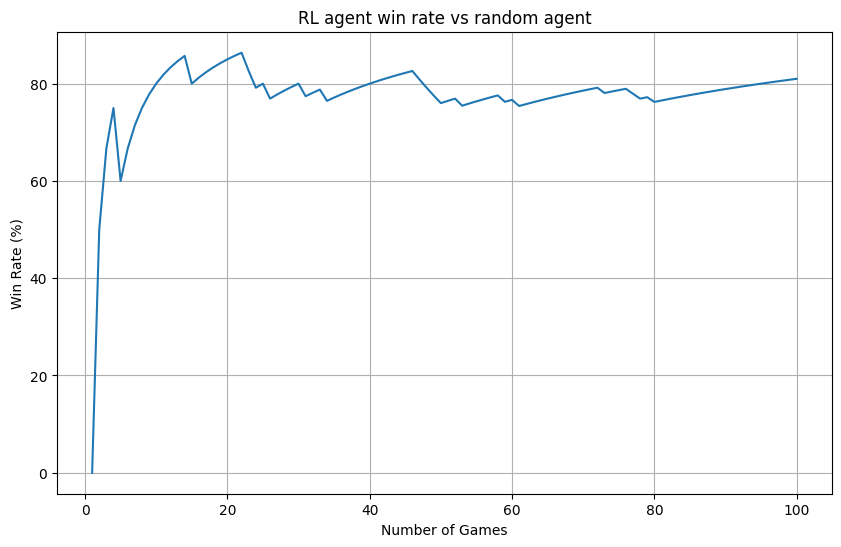

Agent X win rate over 100 games: 81.00%
Wins: 81, Losses: 17, Draws: 2


In [7]:
# Training the agent using Q-learning with function approximation
epsilon = 0.9
alpha = 0.5
gamma = 0.9

# Initialize the board and RLAgent for Tic-Tac-Toe
game_board = Board(size=3)
agent_X = RLAgent('X', epsilon, alpha, gamma)
agent_O = RLAgent('O', epsilon, alpha, gamma)

num_episodes = 5
for episode in range(num_episodes):
    if episode % 1000 == 0:
        print(f"Episode {episode}")

    game_board.reset()
    game_over = False

    while not game_over:
        # Agent X makes a move
        state_old_X = copy.deepcopy(game_board)
        action_X = agent_X.make_move(game_board)
        state_new_X = copy.deepcopy(game_board)

        # Check if the game has ended after Agent X's move
        if game_board.check_winner() == agent_X.symbol:
            reward_X = 1
            agent_X.update_value(state_old_X, action_X, reward_X, state_new_X)
            break
        elif game_board.is_draw():
            reward_X = 0
            agent_X.update_value(state_old_X, action_X, reward_X, state_new_X)
            break
        else:
            reward_X = 0

        # Agent O makes a move
        state_old_O = copy.deepcopy(game_board)
        action_O = agent_O.make_move(game_board)
        state_new_O = copy.deepcopy(game_board)

        # Check if the game has ended after Agent O's move
        if game_board.check_winner() == agent_O.symbol:
            reward_O = 1
            reward_X = -1
            agent_O.update_value(state_old_O, action_O, reward_O, state_new_O)
            agent_X.update_value(state_old_X, action_X, reward_X, state_new_O)
            break
        elif game_board.is_draw():
            reward_O = 0
            reward_X = 0
            agent_O.update_value(state_old_O, action_O, reward_O, state_new_O)
            agent_X.update_value(state_old_X, action_X, reward_X, state_new_O)
            break
        else:
            reward_O = 0

        # Update Q-values for non-terminal states using function approximation
        agent_X.update_value(state_old_X, action_X, reward_X, state_new_O)
        agent_O.update_value(state_old_O, action_O, reward_O, state_new_O)

# Save the weights of the trained agent
agent_X.weights
import random
import matplotlib.pyplot as plt

def play_agent_vs_random(agent_X, game_board, num_games=100):
    wins = 0
    losses = 0
    draws = 0
    win_rates = []

    for i in range(1, num_games + 1):
        game_board.reset()
        game_over = False
        agent_X.epsilon = 0  # Set agent to be greedy (no exploration) during gameplay

        while not game_over:
            # Agent X's turn
            agent_X.make_move(game_board)
            winner = game_board.check_winner()
            if winner == agent_X.symbol:
                wins += 1
                game_over = True
                break
            elif game_board.is_draw():
                draws += 1
                game_over = True
                break

            # Random agent's turn (playing as 'O')
            random_agent_move(game_board, 'O')
            winner = game_board.check_winner()
            if winner == 'O':
                losses += 1
                game_over = True
                break
            elif game_board.is_draw():
                draws += 1
                game_over = True
                break

        # Calculate win rate up to current game
        total_games = wins + losses + draws
        win_rate = (wins / total_games) * 100
        win_rates.append(win_rate)

    # Plot the win rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_games + 1), win_rates, linestyle='-')
    plt.xlabel('Number of Games')
    plt.ylabel('Win Rate (%)')
    plt.title('RL agent win rate vs random agent')
    plt.grid(True)
    plt.show()

    print(f"Agent X win rate over {total_games} games: {win_rate:.2f}%")
    print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}")

def random_agent_move(game_board, symbol):
    valid_moves = game_board.get_available_moves()
    if valid_moves:
        move = random.choice(valid_moves)
        game_board.make_move(move[0], move[1], symbol)

# Add this method to your Board class if it's not already there
def get_available_moves(self):
    available_moves = []
    for i in range(self.size):
        for j in range(self.size):
            if self.board[i][j] == ' ':
                available_moves.append((i, j))
    return available_moves

# Make sure to add get_available_moves to your Board class
Board.get_available_moves = get_available_moves

# Now, you can run the function
play_agent_vs_random(agent_X, game_board, num_games=100)